In [5]:
import torch
import matplotlib.pyplot as plt

mask = torch.load('mask.pt')
mask_permute = torch.load('mask_permute.pt')
artificial_mask = torch.load('artificial_mask.pt')
final_mask = torch.load('final_mask.pt')

In [61]:
class_change = mask != mask_permute
final_mask = torch.logical_and(class_change[2], torch.tensor(artificial_mask))

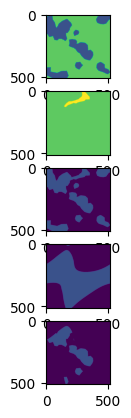

In [63]:
fig, ax = plt.subplots(5)
ax[0].imshow(mask[2].permute(1,2,0), vmin=0, vmax=4)
ax[1].imshow(mask_permute[2].permute(1,2,0), vmin=0, vmax=4)
ax[2].imshow(class_change[2].permute(1,2,0), vmin=0, vmax=4)
ax[3].imshow(torch.tensor(artificial_mask).permute(1,2,0), vmin=0, vmax=4)
ax[4].imshow(final_mask.permute(1,2,0), vmin=0, vmax=4)

In [74]:
import math
import random
import torch

import numpy as np
from scipy.stats import beta

def get_mask(method,x):
    return globals()[method](x)

def combine_masks(x, method=None):
    img, mask = x
    original = img#.deepcopy()
    permute = torch.randperm(img.shape[0])
    class_change = mask != mask[permute]
    artificial_mask = get_mask(method, img)
    final_mask = torch.logical_and(torch.tensor(artificial_mask), class_change)
    return original, img * artificial_mask + img[permute] * (1-artificial_mask), final_mask

def fmix(x):
    return fmix_mask(1., 3, x.shape[-2:], max_soft=0.0, reformulate=False)

def mixup(x):
    lam = beta.rvs(1., 1.)
    return torch.ones_like(x) * lam

def continuous_fmix(x):
    return fmix_mask(1., 3, x.shape[-2:], max_soft=0.5, reformulate=False)

def fftfreqnd(h, w=None, z=None):
    """ Get bin values for discrete fourier transform of size (h, w, z)

    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    fz = fx = 0
    fy = np.fft.fftfreq(h)

    if w is not None:
        fy = np.expand_dims(fy, -1)

        if w % 2 == 1:
            fx = np.fft.fftfreq(w)[: w // 2 + 2]
        else:
            fx = np.fft.fftfreq(w)[: w // 2 + 1]

    if z is not None:
        fy = np.expand_dims(fy, -1)
        if z % 2 == 1:
            fz = np.fft.fftfreq(z)[:, None]
        else:
            fz = np.fft.fftfreq(z)[:, None]

    return np.sqrt(fx * fx + fy * fy + fz * fz)


def get_spectrum(freqs, decay_power, ch, h, w=0, z=0):
    """ Samples a fourier image with given size and frequencies decayed by decay power

    :param freqs: Bin values for the discrete fourier transform
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param ch: Number of channels for the resulting mask
    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    scale = np.ones(1) / (np.maximum(freqs, np.array([1. / max(w, h, z)])) ** decay_power)

    param_size = [ch] + list(freqs.shape) + [2]
    param = np.random.randn(*param_size)

    scale = np.expand_dims(scale, -1)[None, :]

    return scale * param


def make_low_freq_image(decay, shape, ch=1):
    """ Sample a low frequency image from fourier space

    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param ch: Number of channels for desired mask
    """
    freqs = fftfreqnd(*shape)
    spectrum = get_spectrum(freqs, decay, ch, *shape)#.reshape((1, *shape[:-1], -1))
    spectrum = spectrum[:, 0] + 1j * spectrum[:, 1]
    mask = np.real(np.fft.irfftn(spectrum, shape))

    if len(shape) == 1:
        mask = mask[:1, :shape[0]]
    if len(shape) == 2:
        mask = mask[:1, :shape[0], :shape[1]]
    if len(shape) == 3:
        mask = mask[:1, :shape[0], :shape[1], :shape[2]]

    mask = mask
    mask = (mask - mask.min())
    mask = mask / mask.max()
    return mask


def sample_lam(alpha, reformulate=False):
    """ Sample a lambda from symmetric beta distribution with given alpha

    :param alpha: Alpha value for beta distribution
    :param reformulate: If True, uses the reformulation of [1].
    """
    if reformulate:
        lam = beta.rvs(alpha+1, alpha)
    else:
        lam = beta.rvs(alpha, alpha)

    return lam


def binarise_mask(mask, lam, in_shape, max_soft=0.0):
    """ Binarises a given low frequency image such that it has mean lambda.

    :param mask: Low frequency image, usually the result of `make_low_freq_image`
    :param lam: Mean value of final mask
    :param in_shape: Shape of inputs
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :return:
    """
    idx = mask.reshape(-1).argsort()[::-1]
    mask = mask.reshape(-1)
    num = math.ceil(lam * mask.size) if random.random() > 0.5 else math.floor(lam * mask.size)

    eff_soft = max_soft
    if max_soft > lam or max_soft > (1-lam):
        eff_soft = min(lam, 1-lam)

    soft = int(mask.size * eff_soft)
    num_low = num - soft
    num_high = num + soft

    mask[idx[:num_high]] = 1
    mask[idx[num_low:]] = 0
    mask[idx[num_low:num_high]] = np.linspace(1, 0, (num_high - num_low))

    mask = mask.reshape((1, *in_shape))
    return mask


def fmix_mask(alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """ Samples a mean lambda from beta distribution parametrised by alpha, creates a low frequency image and binarises
    it based on this lambda

    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    """
    if isinstance(shape, int):
        shape = (shape,)

    # Choose lambda
    lam = sample_lam(alpha, reformulate)

    # Make mask, get mean / std
    mask = make_low_freq_image(decay_power, shape)
    mask = binarise_mask(mask, lam, shape, max_soft)

    return mask


def sample_and_apply(x, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """

    :param x: Image batch on which to apply fmix of shape [b, c, shape*]
    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    :return: mixed input, permutation indices, lambda value of mix,
    """
    lam, mask = fmix_mask(alpha, decay_power, shape, max_soft, reformulate)
    index = np.random.permutation(x.shape[0])

    x1, x2 = x * mask, x[index] * (1-mask)
    return x1+x2, index, lam

# def mixup(x):
#     """

#     :param x: Image batch on which to apply fmix of shape [b, c, shape*]
#     :param alpha: Alpha value for beta distribution from which to sample mean of mask
#     :param decay_power: Decay power for frequency decay prop 1/f**d
#     :param shape: Shape of desired mask, list up to 3 dims
#     :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
#     :param reformulate: If True, uses the reformulation of [1].
#     :return: mixed input, permutation indices, lambda value of mix,
#     """
#     lam = Beta(torch.tensor([float(0.1)]), torch.tensor([float(0.1)])).sample()
#     index = np.random.permutation(x.shape[0])

#     return x*lam+x[index]*(1-lam)

class FMixBase:
    r""" FMix augmentation

        Args:
            decay_power (float): Decay power for frequency decay prop 1/f**d
            alpha (float): Alpha value for beta distribution from which to sample mean of mask
            size ([int] | [int, int] | [int, int, int]): Shape of desired mask, list up to 3 dims
            max_soft (float): Softening value between 0 and 0.5 which smooths hard edges in the mask.
            reformulate (bool): If True, uses the reformulation of [1].
    """

    def __init__(self, decay_power=3, alpha=1, size=(32, 32), max_soft=0.0, reformulate=False):
        super().__init__()
        self.decay_power = decay_power
        self.reformulate = reformulate
        self.size = size
        self.alpha = alpha
        self.max_soft = max_soft
        self.index = None
        self.lam = None

    def __call__(self, x):
        raise NotImplementedError

    def loss(self, *args, **kwargs):
        raise NotImplementedError

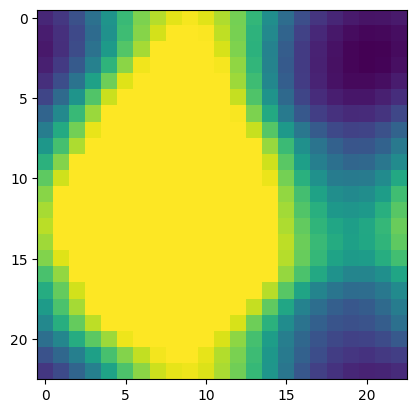

In [76]:
plt.imshow(torch.tensor(get_mask('continuous_fmix', torch.ones(1,23,23))).permute(1,2,0))